In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model

from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

import scipy

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

image_shape = (120, 160, 3)

2025-05-09 11:40:20.404104: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 11:40:20.651163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 11:40:20.651233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 11:40:20.695427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 11:40:20.786100: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [2]:
speed_weight_path = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/speed_model_20250326_1619/speed_model_20250326_1619.weights.h5"

In [3]:
base_model = keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False,
)

feature_extractor = base_model.output

print(feature_extractor.shape)

s_model = []


# model
i = 0

s = feature_extractor

s = layers.Conv2D(32,(3, 3),(2, 2),padding="same",
                  kernel_initializer="he_uniform",name=f"s{i}_conv_1",)(feature_extractor)
s = layers.BatchNormalization(name=f"s{i}_bn_1")(s)
s = layers.Activation("relu", name=f"s{i}_relu_1")(s)
s = layers.GlobalAveragePooling2D(name=f"s{i}_GAP")(s)
# s = layers.Flatten(name=f"s{i}_flatten")(s)

s = layers.Dense(36, activation="relu", kernel_initializer="he_uniform", name=f"s{i}_dense_1")(s)
s = layers.Dropout(0.5, name=f"s{i}_dropout")(s)
s = layers.Dense(3, activation="softmax", name=f"s{i}_output")(s)

s_model.append(s)


outputs_dict = {}

for i in range(len(s_model)):
    outputs_dict[f"speed{i}_output"] = s_model[i]


model = Model(inputs=base_model.input, outputs=outputs_dict, name="speed_model")

model.load_weights(speed_weight_path)


2025-05-09 11:40:24.901959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 11:40:25.029010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 11:40:25.029056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 11:40:25.033932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 11:40:25.033995: I external/local_xla/xla/stream_executor

(None, 4, 5, 576)


In [4]:
# model.summary()

In [5]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [496]:
image_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed"
image_folder = "eight_red_03"

label_df = pd.read_csv(os.path.join(image_dir, image_folder, "_labels.csv")).set_index("image_id")

random_index = label_df.sample(n=1).index[0]

image_path = random_index + ".png"
image_full_path = os.path.join(image_dir, image_folder, image_path)

# image_full_path = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/1743001154965_90_0.png"

label_df.loc[image_path.split(".")[0]]

img = Image.open(image_full_path).resize((image_shape[1], image_shape[0]))  # Adjust size as per your model
img_array = np.array(img) / 255.0 * 2 - 1
img_array = np.expand_dims(img_array, axis=0)

img_array.shape

preds = model.predict(img_array)

1/1 [==============================] - 0s 32ms/step


In [497]:
pred = preds["speed0_output"][0][0] 
true_label = label_df.loc[image_path.split(".")[0]]['speed']

last_conv_layer = model.get_layer('s0_conv_1')

grad_model = tf.keras.models.Model(
    [model.inputs],
    [last_conv_layer.output, model.output]
)

In [498]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions['speed0_output'][0][0]  # First output only

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0014470815658569336..1.0000000298023224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..1.1021236840416402].


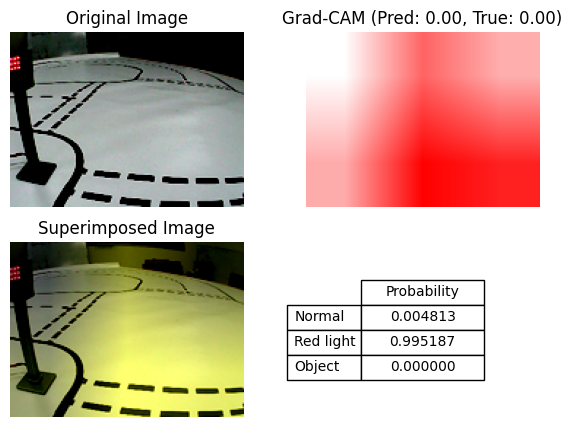

['0.00481', '0.99519', '0.00000']
[0.21333596 0.5743522  0.21231183]


In [499]:
# Generate heatmap
heatmap = tf.reduce_mean(conv_outputs[0] * pooled_grads, axis=-1)
heatmap = np.maximum(heatmap, 0)  # ReLU
heatmap /= np.max(heatmap) + 1e-8  # Normalize

# Resize heatmap
heatmap = Image.fromarray(heatmap).resize((image_shape[1], image_shape[0]), Image.Resampling.BILINEAR)
heatmap = np.array(heatmap)

# Overlay heatmap on original image
original_img = img_array[0]
white_background = np.ones_like(original_img)  # All 1s = white in [0, 1] range
superimposed_img = original_img * 0.6 + heatmap[..., np.newaxis] * [1.0, 1.0, 0.0] * 0.6  # Red heatmap
shaded_img = white_background * (1 - heatmap[..., np.newaxis] * 1.0) + heatmap[..., np.newaxis] * [1.0, 0.0, 0.0] * 1.0
# Visualize
plt.figure(figsize=(7, 5))

# Original image (first row, first column)
plt.subplot(2, 2, 1)  # 2 rows, 3 columns, position 1
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM overlay (first row, second column)
plt.subplot(2, 2, 2)  # 2 rows, 3 columns, position 2
plt.imshow(shaded_img)
plt.title(f"Grad-CAM (Pred: {pred:.2f}, True: {true_label:.2f})")
plt.axis('off')

# Superimposed image (second row, centered across columns 2-3)
plt.subplot(2, 2, 3)  # 2 rows, 3 columns, spanning positions 5 and 6
plt.imshow(superimposed_img)
plt.title("Superimposed Image")
plt.axis('off')


data = [[f"{p:.6f}"] for p in preds["speed0_output"][0]]
columns = ['Probability']
rows = ['Normal', 'Red light', 'Object']

plt.subplot(2, 2, 4)  # 2 rows, 3 columns, spanning positions 5 and 6
table = plt.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center', cellLoc='center')
# table.auto_set_column_width([0])
table.scale(0.5, 1.5)
plt.axis('off')


plt.savefig('gradcam_result.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
print([f"{s:.5f}" for s in preds["speed0_output"][0]])
print(scipy.special.softmax(preds["speed0_output"][0]))

In [507]:
image_shape = (120, 160, 3)

base_model = keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

feature_extractor = base_model.output

a_model = []

output_activation_1 = 'sigmoid'


# model 0
i = 0

a = feature_extractor
a = layers.Conv2D(128, (3, 3), padding='same', 
                  kernel_initializer='he_uniform', name=f'a{i}_conv_2')(feature_extractor)
a = layers.BatchNormalization(name=f'a{i}_bn_2')(a)
a = layers.Activation('relu', name=f'a{i}_relu_2')(a)
a = layers.Conv2D(86, (3, 3), padding='same', 
                  kernel_initializer='he_uniform', name=f'a{i}_conv_1')(feature_extractor)
a = layers.BatchNormalization(name=f'a{i}_bn_1')(a)
a = layers.Activation('relu', name=f'a{i}_relu_1')(a)
a = layers.GlobalAveragePooling2D(name=f'a{i}_GAP')(a)
a = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f'a{i}_dense_2')(a)
a = layers.Dropout(0.5, name=f'a{i}_dropout_2')(a)
a = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name=f'a{i}_dense_1')(a)
a = layers.Dropout(0.3, name=f'a{i}_dropout')(a)

# Branch 1: No arrow (regression, 0 to 1)
arrow_output = layers.Dense(3, activation="softmax", name='no_arrow_output')(a)


model = Model(inputs=base_model.input, outputs=arrow_output, name="angle_model")

weight_path = "Models/angle_model_20250320_0023_arrow_1/angle_model_20250320_0023.weights.h5"

model.load_weights(weight_path)

In [1521]:
image_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed"
image_folder = "T_left"

label_df = pd.read_csv(os.path.join(image_dir, image_folder, "_labels.csv")).set_index("image_id")

random_index = label_df.sample(n=1).index[0]

image_path = random_index + ".png"
image_full_path = os.path.join(image_dir, image_folder, image_path)

# image_full_path = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/1743001154965_90_0.png"

label_df.loc[image_path.split(".")[0]]

img = Image.open(image_full_path).resize((image_shape[1], image_shape[0]))  # Adjust size as per your model
img_array = np.array(img) / 255.0 * 2 - 1
img_array = np.expand_dims(img_array, axis=0)

img_array.shape

preds = model.predict(img_array)

1/1 [==============================] - 0s 30ms/step


In [1522]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [1523]:
out = 1
pred = list(preds[0])
pred_all = pred
pred = pred[out]
true_label = label_df.loc[image_path.split(".")[0]]

true_label = [true_label['left_arrow'], true_label['right_arrow']]

last_conv_layer = model.get_layer('a0_conv_1')

grad_model = tf.keras.models.Model(
    [model.inputs],
    [last_conv_layer.output, model.output]
)

true_label = [0.0 if ((true_label[0] + true_label[1]) == 0) else .0] + true_label

true_label_all = true_label
true_label = true_label[out]

pred, true_label

(0.99512744, 1.0)

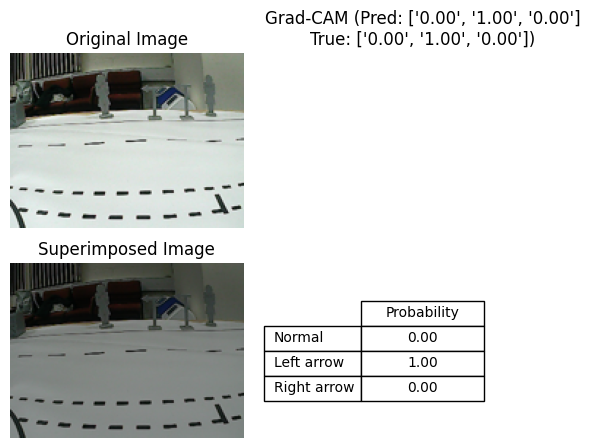

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [1524]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[0][out]  # First output only

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# Generate heatmap
heatmap = tf.reduce_mean(conv_outputs[0] * pooled_grads, axis=-1)
heatmap = np.maximum(heatmap, 0)  # ReLU
heatmap /= np.max(heatmap) + 1e-8  # Normalize

# Resize heatmap
heatmap = Image.fromarray(heatmap).resize((image_shape[1], image_shape[0]), Image.Resampling.BILINEAR)
heatmap = np.array(heatmap)

# Overlay heatmap on original image
original_img = img_array[0] / 2 + 0.5
white_background = np.ones_like(original_img)  # All 1s = white in [0, 1] range
superimposed_img = original_img * 0.6 + heatmap[..., np.newaxis] * [1.0, 1.0, 0.0] * 0.6  # Red heatmap
shaded_img = white_background * (1 - heatmap[..., np.newaxis] * 1.0) + heatmap[..., np.newaxis] * [1.0, 0.0, 0.0] * 1.0
# Visualize
plt.figure(figsize=(7, 5))

# Original image (first row, first column)
plt.subplot(2, 2, 1)  # 2 rows, 3 columns, position 1
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

pred_all = [f"{p:.2f}" for p in pred_all]
true_label_all = [f"{p:.2f}" for p in true_label_all]
# Grad-CAM overlay (first row, second column)
plt.subplot(2, 2, 2)  # 2 rows, 3 columns, position 2
plt.imshow(shaded_img)
plt.title(f"Grad-CAM (Pred: {pred_all}\nTrue: {true_label_all})")
plt.axis('off')

# Superimposed image (second row, centered across columns 2-3)
plt.subplot(2, 2, 3)  # 2 rows, 3 columns, spanning positions 5 and 6
plt.imshow(superimposed_img)
plt.title("Superimposed Image")
plt.axis('off')


data = np.transpose([pred_all])
columns = ['Probability']
rows = ['Normal', 'Left arrow', 'Right arrow']

plt.subplot(2, 2, 4)  # 2 rows, 3 columns, spanning positions 5 and 6
table = plt.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center', cellLoc='center')
# table.auto_set_column_width([0])
table.scale(0.5, 1.5)
plt.axis('off')


plt.savefig('gradcam_result.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
print([f"{s:.5f}" for s in preds["speed0_output"][0]])
print(scipy.special.softmax(preds["speed0_output"][0]))